In [1]:
import pandas as pd 
from pathlib import Path 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

DATA = Path("./data/")

df = pd.read_csv(DATA / "set.csv")

In [2]:
#train/test 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
df_train = train.copy()

In [4]:
df_train.shape[0]

9600

In [5]:
#correlatin 

corr_matrix = df_train.corr(numeric_only=True)

corr_matrix['body_fat_pct'].sort_values(ascending=False)

body_fat_pct              1.000000
systolic_bp               0.563784
ldl_mg_dL                 0.539399
run_5k_min                0.521121
diastolic_bp              0.520965
bmi                       0.452657
age                       0.439301
resting_hr                0.419300
weight_kg                 0.108072
sleep_hours               0.074451
calorie_intake            0.057340
stress_level              0.015903
smoker                    0.014867
alcohol_units_per_week    0.011681
id                        0.004894
triglycerides_mg_dL       0.000008
protein_g                -0.024831
steps_per_day            -0.043404
weekly_workouts          -0.095945
squat_1rm_kg             -0.216687
bench_1rm_kg             -0.252270
max_pushups              -0.426329
height_cm                -0.454491
hdl_mg_dL                -0.594210
vo2max                   -0.716893
Name: body_fat_pct, dtype: float64

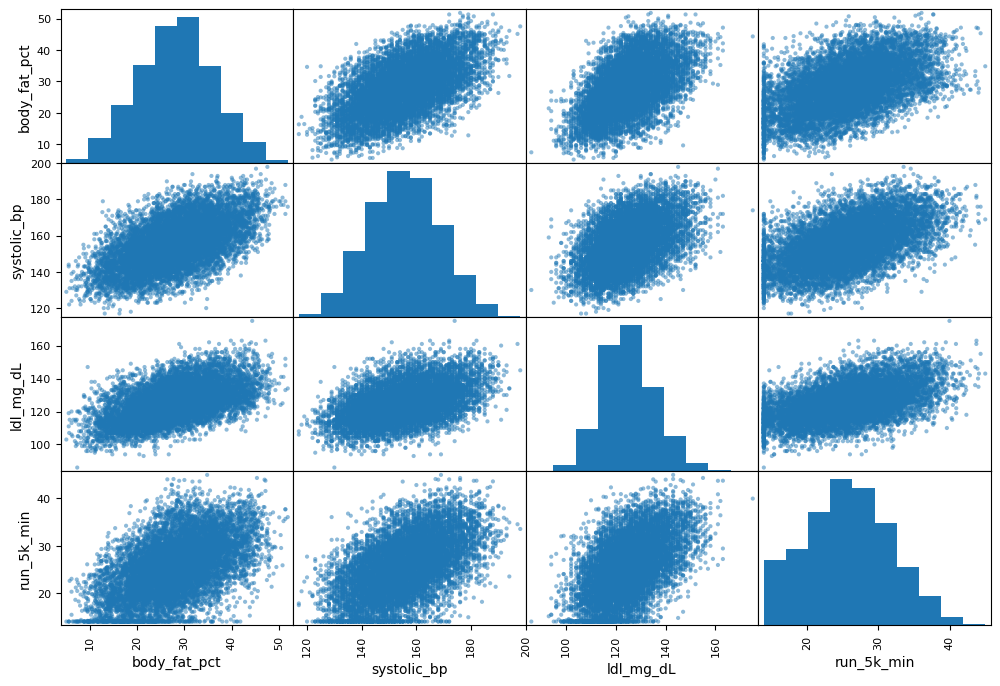

In [6]:
from pandas.plotting import scatter_matrix 

attributes = ["body_fat_pct", "systolic_bp","ldl_mg_dL", "run_5k_min"]
scatter_matrix(df_train[attributes], figsize=(12, 8))
plt.show()

In [7]:
#labels and the rest 

df_train = train.drop("body_fat_pct", axis=1)
df_train_labels = train["body_fat_pct"].copy()

In [8]:
#cleaning 

df_train.isna().sum()

id                        0
month                     0
age                       0
sex                       0
height_cm                 0
weight_kg                 0
bmi                       0
weekly_workouts           0
steps_per_day             0
sleep_hours               0
stress_level              0
calorie_intake            0
protein_g                 0
alcohol_units_per_week    0
smoker                    0
vo2max                    0
run_5k_min                0
resting_hr                0
systolic_bp               0
diastolic_bp              0
bench_1rm_kg              0
squat_1rm_kg              0
max_pushups               0
ldl_mg_dL                 0
hdl_mg_dL                 0
triglycerides_mg_dL       0
dtype: int64

In [9]:
#num data 
df_train_num = df_train.select_dtypes(include=[np.number])

In [10]:
#выбросы 
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(df_train_num)

In [11]:
outlier_pred 

array([ 1, -1, -1, ...,  1,  1,  1])

In [12]:
count_outlier = pd.DataFrame(outlier_pred, columns=["outlier_flag"], index=df_train_num.index)
count_outlier.value_counts()

outlier_flag
 1              8322
-1              1278
Name: count, dtype: int64

In [13]:
df_train = df_train.iloc[outlier_pred == 1]
df_train_labels = df_train_labels.iloc[outlier_pred == 1]

Pipeline

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
#test with customs trans
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out='one-to-one')



custom_pipeline = Pipeline([
    ('log', log_transformer)
])
# Автоматический выбор признаков по типу
numeric_features = make_column_selector(dtype_include='number')
categorical_features = make_column_selector(dtype_include='object')

# Пайплайн для числовых признаков
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных признаков
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


full_pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_features),
        ('categorical', categorical_pipeline, categorical_features),
        ('custom', custom_pipeline, ['calorie_intake'])
    ])
)


LinearRegression

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(full_pipeline, LinearRegression())
lin_reg.fit(df_train, df_train_labels)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000002777890AA50>),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy=...frequent')),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000002777894B680>),
                                                                  ('custom',
                                                                   Pipeline(steps=[('log',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log'>,
                                                                                                        inverse_func=<ufunc 'exp'>))]),
                                                                   ['calorie_intake'])]))])),
                ('linearregression', LinearRegression())])

In [16]:
predictions = lin_reg.predict(df_train)

In [17]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse = root_mean_squared_error(df_train_labels, predictions)
lin_mae = mean_absolute_error(df_train_labels, predictions)

print(f"RMSE: {lin_rmse}")
print(f"MAE: {lin_rmse}")

RMSE: 2.1820589292463657
MAE: 2.1820589292463657


In [18]:
#cross-valid 
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_maes = -cross_val_score(lin_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Средний RMSE:", lin_rmses.mean())
print("Средний MAE:", lin_maes.mean())

Средний RMSE: 2.1905235792308506
Средний MAE: 1.7479717812682734


RandomForestRegressor

In [52]:
from sklearn.ensemble import RandomForestRegressor

# создаём пайплайн: препроцессинг + случайный лес
rf_reg = make_pipeline(
    full_pipeline,
    RandomForestRegressor(
        n_estimators=200,      # количество деревьев
        max_depth=None,        # глубина деревьев (None = до упора)
        min_samples_split=2,   # минимальное число объектов для разбиения
        random_state=42,
        n_jobs=-1              # использовать все ядра процессора
    )
)

# обучение на тренировочных данных
rf_reg.fit(df_train, df_train_labels)

# предсказания
forest_predictions = rf_reg.predict(df_train)

In [53]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, forest_predictions, squared=False)

rf_rmse = root_mean_squared_error(df_train_labels, forest_predictions)
rf_mae = mean_absolute_error(df_train_labels, forest_predictions)

print(f"RMSE: {rf_rmse}")
print(f"MAE: {rf_rmse}")

RMSE: 0.6511091117028432
MAE: 0.6511091117028432


In [54]:
#cross-valid 
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(rf_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_maes = -cross_val_score(rf_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Средний RMSE:", lin_rmses.mean())
print("Средний MAE:", lin_maes.mean())

KeyboardInterrupt: 

XGBoost

In [46]:
from xgboost import XGBRegressor

# пайплайн: препроцессинг + XGBoost
xgb_reg = make_pipeline(
    full_pipeline,
    XGBRegressor(
        n_estimators=500,      # количество деревьев (итераций бустинга)
        learning_rate=0.05,    # скорость обучения
        max_depth=6,           # глубина деревьев
        subsample=0.8,         # доля данных для каждого дерева
        colsample_bytree=0.8,  # доля признаков для каждого дерева
        random_state=42,
        n_jobs=-1
    )
)

# обучение
xgb_reg.fit(df_train, df_train_labels)

# предсказания
xgb_predictions = xgb_reg.predict(df_train)

In [47]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, xgb_predictions, squared=False)

xgb_rmse = root_mean_squared_error(df_train_labels, xgb_predictions)
xgb_mae = mean_absolute_error(df_train_labels, xgb_predictions)

print(f"RMSE: {xgb_rmse}")
print(f"MAE: {xgb_rmse}")

RMSE: 0.7974637908289045
MAE: 0.7974637908289045


In [48]:
#cross-valid 
from sklearn.model_selection import cross_val_score

xgb_rmses = -cross_val_score(xgb_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
xgb_maes = -cross_val_score(xgb_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Средний RMSE:", xgb_rmses.mean())
print("Средний MAE:", xgb_maes.mean())

Средний RMSE: 1.7240831820429787
Средний MAE: 1.365083826067254


Настройки гиперпараметров лучшей модели

In [31]:
entire_pipeline = Pipeline([
    ("preprocessing", full_pipeline),
    ("xgb", XGBRegressor()),
])

#witch params there are
print(str(entire_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'xgb', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__columntransformer', 'preprocessing__columntransformer__force_int_remainder_cols', 'preprocessing__columntransformer__n_jobs', 'preprocessing__columntransformer__remainder', 'preprocessing__columntransformer__sparse_threshold', 'preprocessing__columntransformer__transformer_weights', 'preprocessing__columntransformer__transformers', 'preprocessing__columntransformer__verbose', 'preprocessing__columntransformer__verbose_feature_names_out', 'preprocessing__columntransformer__numeric', 'preprocessing__columntransformer__categorical', 'preprocessing__columntransformer__custom', 'preprocessing__columntransformer__numeric__memory', 'preprocessing__columntransformer__numeric__steps', 'preprocessing__columntransformer__numeric__verbose', 'preprocessing__columntransformer__numeric__imputer', 'preprocessing__columntransformer__numeric__scaler'

In [42]:
#random research 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'xgb__n_estimators': [100, 300, 500, 700],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 6, 8],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__random_state': [42],  # фиксируем для воспроизводимости
    'xgb__n_jobs': [-1]         # используем все ядра
}


rnd_search = RandomizedSearchCV(
    entire_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(df_train, df_train_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('numeric',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x000002777890AA50>),
                                                                                               ('categorical',
                                                                                                Pipeline(st...
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None, ...))]),
                   param_distributions={'xgb__colsample_bytree': [0.6, 0.8,
                                                                  1.0],
                                        'xgb__learning_rate': [0.01, 0.05, 0.1,
                                                               0.2],
                                        'xgb__max_depth': [3, 5, 6, 8],
                                        'xgb__n_estimators': [100, 300, 500,
                                                              700],
                                        'xgb__n_jobs': [-1],
                                        'xgb__random_state': [42],
                                        'xgb__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [33]:
rnd_search.best_params_

{'xgb__subsample': 0.8,
 'xgb__n_estimators': 700,
 'xgb__max_depth': 6,
 'xgb__learning_rate': 0.05,
 'xgb__colsample_bytree': 0.6}

In [34]:
best_model = rnd_search.best_estimator_
predictions = best_model.predict(df_train)

In [35]:
best_rmses = -cross_val_score(best_model, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(best_rmses).describe()

count    10.000000
mean      1.689788
std       0.042099
min       1.593412
25%       1.673588
50%       1.694796
75%       1.722142
max       1.737763
dtype: float64

In [37]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["xgb"].feature_importances_
feature_importances.round(2)

array([0.  , 0.01, 0.  , 0.01, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.42, 0.5 , 0.  ], dtype=float32)

In [38]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.49544552, 'categorical__sex_male'),
 (0.41888055, 'categorical__sex_female'),
 (0.02424044, 'numeric__vo2max'),
 (0.016052738, 'numeric__bmi'),
 (0.0066204267, 'numeric__age'),
 (0.005135217, 'numeric__weight_kg'),
 (0.004726889, 'numeric__smoker'),
 (0.004541074, 'numeric__hdl_mg_dL'),
 (0.0031297249, 'numeric__height_cm'),
 (0.002189582, 'numeric__squat_1rm_kg'),
 (0.0017910507, 'numeric__ldl_mg_dL'),
 (0.0017566828, 'numeric__systolic_bp'),
 (0.0015465559, 'numeric__bench_1rm_kg'),
 (0.0013675137, 'numeric__weekly_workouts'),
 (0.0013250806, 'numeric__diastolic_bp'),
 (0.0012154958, 'numeric__steps_per_day'),
 (0.0011321141, 'numeric__calorie_intake'),
 (0.0011282616, 'custom__calorie_intake'),
 (0.0010456517, 'numeric__sleep_hours'),
 (0.00084016967, 'numeric__id'),
 (0.0006227355, 'numeric__protein_g'),
 (0.000575728, 'numeric__run_5k_min'),
 (0.0005755669, 'numeric__alcohol_units_per_week'),
 (0.00043373532, 'numeric__resting_hr'),
 (0.00040718119, 'numeric__max_pushups'),
 (

Test probe

In [39]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

X_test = test.drop("body_fat_pct", axis=1)
y_test = test["body_fat_pct"].copy()

final_predictions = final_model.predict(X_test)

# === Метрики ===
final_rmse = root_mean_squared_error(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)

print(f"RMSE: {final_rmse:.2f}")
print(f"MAE:  {final_mae:.2f}")


RMSE: 1.81
MAE:  1.42


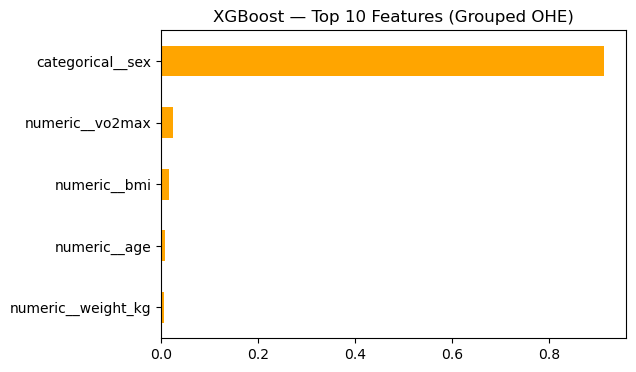

In [ ]:

feat_imp = pd.Series(
    final_model.named_steps['xgb'].feature_importances_,
    index=final_model.named_steps['preprocessing'].get_feature_names_out()
)

# Объединяем OHE-признаки, которые принадлежат одной категории
feat_imp_grouped = feat_imp.copy()
feat_imp_grouped.index = feat_imp_grouped.index.str.replace(r'categorical__sex_.*', 'categorical__sex', regex=True)
feat_imp_grouped = feat_imp_grouped.groupby(level=0).sum().sort_values(ascending=True)

# Строим график
feat_imp_grouped.tail(5).plot(kind='barh', figsize=(6,4), color='orange',
                               title='XGBoost — Top 5 Features (Grouped OHE)')

plt.savefig('out/img/XGBoost: XGBoost — Top 5 Features.png', dpi=300)
plt.show()

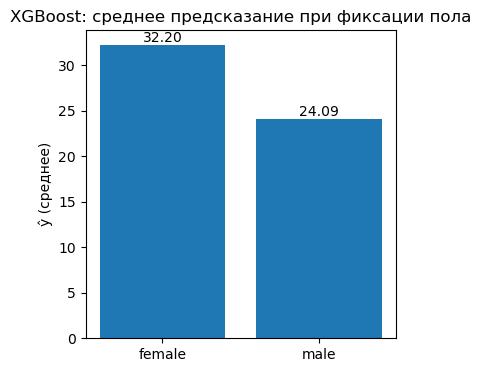

In [ ]:
def plot_sex_effect(pipeline, X_test, y_test=None, title='Модель'):
    Xm = X_test.copy();  Xm['sex'] = 'male'
    Xf = X_test.copy();  Xf['sex'] = 'female'
    pm = pipeline.predict(Xm).mean()
    pf = pipeline.predict(Xf).mean()

    vals = [pf, pm]
    plt.figure(figsize=(4,4))
    plt.bar(['female','male'], vals)
    plt.title(f'{title}: среднее предсказание при фиксации пола')
    plt.ylabel('ŷ (среднее)')
    for i,v in enumerate(vals): plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
    plt.savefig('out/img/XGBoost: sex.png', dpi=300)
    plt.show()


plot_sex_effect(final_model, X_test, title='XGBoost')


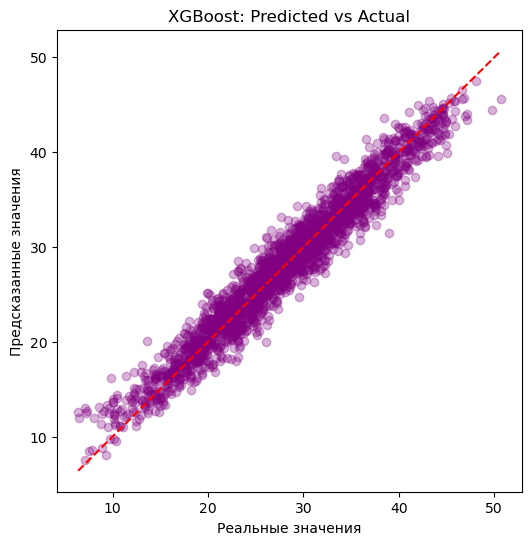

In [ ]:
y_pred_xgb = final_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('XGBoost: Predicted vs Actual')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.savefig('out/img/XGBoost: Predicted vs Actual.png', dpi=300)
plt.show()


Save

In [ ]:
import joblib
joblib.dump(final_model, "out/models/linear_body_fat_pct.pkl")

['out/linear_body_fat_pct.pkl']